# 2D Heatmaps with different values in the 2 Hemispjere

This notebook, located in the project's folder, generates a series of 2D heatmaps using BrainRender. The values for the two hemispheres are different.

**Attention**: Due to the fact a whole image is created by mergiging 2 halves images, users should be cautious about where to split the images (i.e., splitting in the middle may not always be the best choice). Users can adjust these settings later in the notebook.

### Notebook Workflow

The notebook follows these steps:

1. **Prompt for Mandatory Inputs and Parameters**:
   - Requests necessary inputs and parameters from the user.

2. **Define Utility Functions**:
   - `split_and_merge_png_images()`: Given two images, this function saves a new image that merges the two halves of the original images.
   - `find_measurement_dirs()`: Given the main directory, this function returns a list of all `_Measurement` directories (one for each brain).

3. **Locate CSV Files**:
   - Finds the CSV file for each brain containing the sample density for each ROI.

4. **Generate Heatmap Images**:
   - **Read CSV File**: Reads the relevant CSV file for each brain.
   - **Create Result Folder**: Creates a folder for storing the results of the current brain.
   - **Create Left Heatmaps**: Generates heatmaps for the left hemisphere.
   - **Create Right Heatmaps**: Generates heatmaps for the right hemisphere.
   - **Merge Heatmaps**: Merges the left and right heatmaps.

5. **Create a Video**:
   - Compiles the heatmaps into a video.

### Packages

**Attention**: The notebook should be run in a kernel (VE) created with the file [brainrender-env.yml](assets/yml/brainrender-env.yml). Use the following command to create a virtual environment:

   ```bash
     conda env create -f brainrender-env.yml
   ```

**Attention**: To correctly execute the notebook, you must create a new function `my_plot()` in the `heatmap.py` script. This file is located in the `brainrender-env/lib/python3.9/site-packages/brainglobe_heatmap` directory of your virtual environment. The file [my_plot_heatmap_brainrender.txt](assets/my_plot_heatmap_brainrender.txt) contains the function that you can paste.

**Attention**: To create a video, you need to install the following libraries: `conda install -c conda-forge opencv`.

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import brainglobe_heatmap as bgh #Please use a VE where brainrender is installed
from brainglobe_atlasapi import BrainGlobeAtlas
from PIL import Image
import cv2
import re
import matplotlib.colors as mcolors


# Mandatory Inputs

In [2]:
# Dir of the project
dir_project = "/run/user/1000/gvfs/smb-share:server=upcourtinenas,share=cervical/CERVICAL_ID/connectome_analysis/final_dataset"

# Tell if you want to run the notebook in test mode, i.e. only process the first n brains
test = True #flag this if you want to run the script in debugging mode, i.e only few brains processed
n_test = 2 #how many brains use for testing

# If you want to run the notebook for a single braain and not the whole project, replace None with the Folder _Measurement of the brain to analyze
single_brain = None 
    #if you want:
        #run the script for all the brains in the project: single brain = None
        #run the script for a specific brain; single_brain = "path_to_Measuremets_dir"

# Choose how many slices show, initial and final cuts
start_cut = 0 #from olfacotry bulb
end_cut = 13000 #to myelenchephalon
step = 5000

# Select an atlas
atlas_name = "allen_mouse_50um"
bg_atlas = BrainGlobeAtlas(atlas_name, check_latest=False)

# Show or not colorbar in final images
show_colorbar = False

# Show only leaves nodes
only_leaves = False

# fps of the video
fps = 5

# Choose the fraction of the colormap to start from (0.0 = start, 1.0 = end)
start_fraction = 0.1  # Adjust this value as needed

# Useful Function

In [3]:
def split_and_merge_png_images(image_path_left, image_path_right, output_path, left_ratio=0.493, right_ratio=0.507):
    """
    Splits and merges two PNG images with the specified ratio for each side.

    :param image_path1: Path to the left image.
    :param image_path2: Path to the right image.
    :param output_path: Path to save the combined image.
    :param left_ratio: Ratio of the width to take from the left image.
    :param right_ratio: Ratio of the width to take from the right image.
    """
    # Load PNG images
    img1 = Image.open(image_path_left)
    img2 = Image.open(image_path_right)

    # Ensure images have the same height
    if img1.size[1] != img2.size[1]:
        raise ValueError("Images must have the same height.")

    # Get image dimensions
    width1, height1 = img1.size
    width2, height2 = img2.size

    # Calculate cropping dimensions based on the provided ratios
    left_crop_width = int(width1 * left_ratio)
    right_crop_width = int(width2 * right_ratio)

    # Crop each image according to the calculated dimensions
    left_half_img1 = img1.crop((0, 0, left_crop_width, height1))
    right_half_img2 = img2.crop((width2 - right_crop_width, 0, width2, height2))

    # Save the intermediate halves --> TEST WHERE TO CUT!!!
    #left_half_img1.save('left_half.png')
    #right_half_img2.save('right_half.png')

    # Create a new image with combined width
    new_width = left_half_img1.width + right_half_img2.width
    new_image = Image.new('RGB', (new_width, height1))

    # Paste halves into the new image
    new_image.paste(left_half_img1, (0, 0))
    new_image.paste(right_half_img2, (left_half_img1.width, 0))

    # Save the combined image
    print(f"Saving merged heatmap {output_path}")
    new_image.save(output_path)

def find_measurement_dirs(base_directory):
    """
    Recursively searches for directories named '_Measurements' in the specified base directory,
    excluding directories named 'data' and 'classifiers'.

    Args:
        base_directory (str): The base directory path to start the search from.

    Returns:
        list: A list of paths to directories named '_Measurement'.
    """
    measurement_dirs = []

    # Traverse the directory tree
    for dirpath, dirnames, _ in os.walk(base_directory):

        # Remove 'data' and 'classifiers' from search --> faster research
        dirnames[:] = [d for d in dirnames if d not in ('data', 'classifiers', "FB_1","FB_2", "HB_1", "HB_2")]
        
        # Check for '_measurement' directory
        if '_Measurements' in dirnames:
            full_path = os.path.join(dirpath, '_Measurements')
            measurement_dirs.append(full_path)
            #print(f"Found directory: {full_path}")

            print(f"_Measuremets file found until now: {len(measurement_dirs)}")

        #if in test mode, exit after havgin processed exalty n_test brainrs
        if test and len(measurement_dirs) == n_test: break

    return measurement_dirs

def extract_number(filename):
    """
    Extract the number from the filename.
    Assumes filename is in the format 'number.png'.
    """
    match = re.search(r'(\d+)', filename)
    return int(match.group(1)) if match else 0

def create_custom_cmap(start_fraction=0.1):
    """
    Create a custom colormap starting from a specific fraction of the Reds colormap.
    
    Parameters:
    start_fraction (float): Fraction of the Reds colormap to start from (0.0 to 1.0).
    
    Returns:
    LinearSegmentedColormap: A custom colormap starting from the specified fraction.
    """
    # Ensure the starting fraction is within the range [0, 1]
    start_fraction = np.clip(start_fraction, 0, 1)
    
    # Get the 'Reds' colormap
    reds = plt.get_cmap('Reds')

    # Extract the colormap data
    n_colors = reds.N
    colors = reds(np.linspace(0, 1, n_colors))

    # Calculate the index to start from
    start_index = int(start_fraction * (n_colors - 1))
    
    # Create the custom colormap starting from the chosen fraction
    custom_colors = colors[start_index:]
    custom_cmap = mcolors.LinearSegmentedColormap.from_list('custom_reds', custom_colors)
    
    return custom_cmap


# Find _Measurement folders and csv files

In [4]:
# Find all "_Measurements" directories
if single_brain == None:
    measurement_directories = find_measurement_dirs(dir_project)
else:
    measurement_directories = single_brain

# Find all "whole_brain.csv" file
csv_files = [csv+"/whole_brain.csv" for csv in measurement_directories]

print("\ncsv files:")
print(csv_files)

_Measuremets file found until now: 1
_Measuremets file found until now: 2

csv files:
['/run/user/1000/gvfs/smb-share:server=upcourtinenas,share=cervical/CERVICAL_ID/connectome_analysis/final_dataset/DR/8 weeks/100/_Measurements/whole_brain.csv', '/run/user/1000/gvfs/smb-share:server=upcourtinenas,share=cervical/CERVICAL_ID/connectome_analysis/final_dataset/DR/8 weeks/101/_Measurements/whole_brain.csv']


# Create Custum cmap

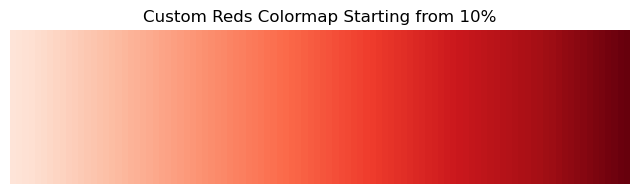

In [5]:
# Create the custom colormap
    #chnage "start_fraction" to start the colormap from a higher or lower color
custom_cmap = create_custom_cmap(start_fraction=start_fraction)

# Test the custom colormap
data = np.linspace(0, 1, 100).reshape(1, -1)
plt.figure(figsize=(8, 2))
plt.imshow(data, aspect='auto', cmap=custom_cmap)
plt.axis('off')
plt.title(f'Custom Reds Colormap Starting from {start_fraction * 100:.0f}%')
plt.show()

# Creates Images

In [6]:
# For each brain creates a set of images
for i, csv_file in enumerate(csv_files):

    print(f"\nProcessing {i+1}th brain: " + csv_file)

    # Read csv file
    df = pd.read_csv(csv_file)

    ##############################################
    ### CREATE FOLDERS ###########################
    ##############################################

    # Make a dir for images (if doesn't yet exist)
    grandparent_folder = os.path.dirname(os.path.dirname(csv_file)) #take the granparent folder (2 layer above the csv file)
    dir_images_name = grandparent_folder + "/Results/2D_heatmaps"
    print(dir_images_name)
    os.makedirs(dir_images_name, exist_ok=True)

    #Create a folder where to store them
    heatmaps_dir_left = os.path.join(dir_images_name, "Left")
    heatmaps_dir_right = os.path.join(dir_images_name, "Right")
    heatmaps_dir_merged = os.path.join(dir_images_name,"Merged") 
    os.makedirs(heatmaps_dir_left, exist_ok=True)
    os.makedirs(heatmaps_dir_right, exist_ok=True)
    os.makedirs(heatmaps_dir_merged, exist_ok=True)

    ##############################################
    ### OBSERVATIONS #############################
    ##############################################

    # Attention: The heatmas will show all regions, not a subset of the most dense

    ##############################################
    ### CREATE HEATMAPS LEFT #####################
    ##############################################

    side = "Left"

    df_side = df[df["Side"] == side]  # Take the ROI only from one side

    if only_leaves: # To display only the leaves ROIs
        df_side = df[df["IsLeaf"] == True]

    # Use only the ROI that are present in the atlas
    df_side = df_side[df_side['Region'].isin(bg_atlas.lookup_df["acronym"].to_list())]

    # Create the dictionary --> NB take the name withounf left or right
    # ex: dict{"CA1": 10, "ENT": 40, ...}
    cell_density_data = dict(zip(df_side['Region'], df_side['Cell Density']))

    #print(cell_density_data)

    # Iterate over cuts range
    for cut in range(start_cut, end_cut+1, step): # +1 so I can take alos the last slice

        print(f"Porcessing cut number {side}-{cut}")
        
        # Create Heatmap object
        f = bgh.Heatmap(
            cell_density_data,
            position=cut,
            orientation="frontal",  # Adjust orientation as needed
            title="", #f"Side: {side} - Slice position: {cut}",
            vmin=0,
            vmax=0.01,
            cmap=custom_cmap,
            atlas_name=atlas_name,
            format='2D', 
            hemisphere=side.lower(), #Attention lower case
            label_regions=False
        )
        
        # Save the figure
        fig = f.my_plot(show_colorbar=show_colorbar, show_legend=False, xlabel="", ylabel="", hide_axes=True) 
            # ATTENTION: MY PLOT IS A CUSTUM FUNCTION
                #just go in the file brainrender-env/lib/python3.9/site-packages/brainglobe_heatmap/heatmaps.py
                #create a new fucntion my_plot that copies the function plot()
                #and comment out the plt.show() at the end
        fig_path = os.path.join(dir_images_name, side, f'{cut}.png')
        fig.savefig(fig_path, dpi=100)
        print(f"Saved figure: {cut}.png\n")
        plt.close(fig)  # Close the figure to free memory

    
    ##############################################
    ### CREATE HEATMAPS RIGHT #####################
    ##############################################

    # Attention: Show all regions, not a subset of the most dense

    side = "Right"

    df_side = df[df["Side"] == side]  # Take the ROI only from one side

    if only_leaves: # To display only the leaves ROIs
        df_side = df[df["IsLeaf"] == True]

    # Use only the ROI that are present in the atlas
    df_side = df_side[df_side['Region'].isin(bg_atlas.lookup_df["acronym"].to_list())]

    # Create the dictionary --> NB take the name withounf left or right
    # ex: dict{"CA1": 10, "ENT": 40, ...}
    cell_density_data = dict(zip(df_side['Region'], df_side['Cell Density']))

    #print(cell_density_data)

    # Iterate over cuts range
    for cut in range(start_cut, end_cut+1, step): # +1 so I can take alos the last slice

        print(f"Porcessing cut number {side}-{cut}")
        
        # Create Heatmap object
        f = bgh.Heatmap(
            cell_density_data,
            position=cut,
            orientation="frontal",  # Adjust orientation as needed
            title="", #f"Side: {side} - Slice position: {cut}",
            vmin=0,
            vmax=0.01,
            cmap=custom_cmap,
            atlas_name=atlas_name,
            format='2D', 
            hemisphere=side.lower(), #Attention lower case
            label_regions=False
        )
        
        # Save the figure
        fig = f.my_plot(show_colorbar=show_colorbar, show_legend=False,xlabel="", ylabel="", hide_axes=True) 
            # ATTENTION: MY PLOT IS A CUSTUM FUNCTION
                #just go in the file brainrender-env/lib/python3.9/site-packages/brainglobe_heatmap/heatmaps.py
                #create a new fucntion my_plot that copies the function plot()
                #and comment out the plt.show() at the end
        fig_path = os.path.join(dir_images_name, side, f'{cut}.png')
        fig.savefig(fig_path, dpi=100)
        print(f"Saved figure: {cut}.png\n")
        plt.close(fig)  # Close the figure to free memory


    ##############################################
    ### MERGE IMAGES #############################
    ##############################################
    
    for root, dirs, files in os.walk(heatmaps_dir_left):
        for file in files:
            file_path_left = os.path.join(heatmaps_dir_left, file) #path fo the file
            file_path_right = os.path.join(heatmaps_dir_right, file)
            file_path_merged = os.path.join(heatmaps_dir_merged, file)
            split_and_merge_png_images(image_path_left=file_path_right, #ATTENTION, are inverted
                                        image_path_right=file_path_left,  
                                        output_path=file_path_merged, 
                                        left_ratio=0.511,right_ratio=0.489)
            
            #ATTENTION: ratios
                # if colormap is there: left_ratio=0.493,right_ratio=0.507
                # if colormap is NOT there: left_ratio=0.511,right_ratio=0.489


    ##############################################
    ### VIDEO ####################################
    ##############################################

    # Path of the video to save
    video_path = heatmaps_dir_merged + '/video_merged_heatmaps.mp4'

    # Get the list of image files in the folder
    images = [img for img in os.listdir(heatmaps_dir_merged) if img.endswith(".png")]
    images.sort(key=extract_number)  # important to sort in the correct way

    # Read the first image to get the width and height
    first_image = cv2.imread(os.path.join(heatmaps_dir_merged, images[0]))
    height, width, layers = first_image.shape

    # Define the codec and create VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'XVID')  # You can use 'MJPG' or 'MP4V' if preferred
    video = cv2.VideoWriter(video_path, fourcc, fps, (width, height))  # 1 is the frame rate

    for image in images:
        image_path = os.path.join(heatmaps_dir_merged, image)
        img = cv2.imread(image_path)
        video.write(img)  # Write each frame to the video

    # Release the video writer object
    video.release()
    cv2.destroyAllWindows()

    print(f"\nVideo creation complete at {video_path}\n")







Processing 1th brain: /run/user/1000/gvfs/smb-share:server=upcourtinenas,share=cervical/CERVICAL_ID/connectome_analysis/final_dataset/DR/8 weeks/100/_Measurements/whole_brain.csv
/run/user/1000/gvfs/smb-share:server=upcourtinenas,share=cervical/CERVICAL_ID/connectome_analysis/final_dataset/DR/8 weeks/100/Results/2D_heatmaps
Porcessing cut number Left-0
The region RSPd4 is in the onthology but does not have a corresponding volume in the atlas being used: allen_mouse_50um. Skipping
Saved figure: 0.png

Porcessing cut number Left-5000
The region RSPd4 is in the onthology but does not have a corresponding volume in the atlas being used: allen_mouse_50um. Skipping
Saved figure: 5000.png

Porcessing cut number Left-10000
The region RSPd4 is in the onthology but does not have a corresponding volume in the atlas being used: allen_mouse_50um. Skipping
Saved figure: 10000.png

Porcessing cut number Right-0
The region RSPd4 is in the onthology but does not have a corresponding volume in the atla

OpenCV: FFMPEG: tag 0x44495658/'XVID' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'



Video creation complete at /run/user/1000/gvfs/smb-share:server=upcourtinenas,share=cervical/CERVICAL_ID/connectome_analysis/final_dataset/DR/8 weeks/100/Results/2D_heatmaps/Merged/video_merged_heatmaps.mp4


Processing 2th brain: /run/user/1000/gvfs/smb-share:server=upcourtinenas,share=cervical/CERVICAL_ID/connectome_analysis/final_dataset/DR/8 weeks/101/_Measurements/whole_brain.csv
/run/user/1000/gvfs/smb-share:server=upcourtinenas,share=cervical/CERVICAL_ID/connectome_analysis/final_dataset/DR/8 weeks/101/Results/2D_heatmaps
Porcessing cut number Left-0
The region RSPd4 is in the onthology but does not have a corresponding volume in the atlas being used: allen_mouse_50um. Skipping
Saved figure: 0.png

Porcessing cut number Left-5000
The region RSPd4 is in the onthology but does not have a corresponding volume in the atlas being used: allen_mouse_50um. Skipping
Saved figure: 5000.png

Porcessing cut number Left-10000
The region RSPd4 is in the onthology but does not have a correspo

OpenCV: FFMPEG: tag 0x44495658/'XVID' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


## To see where to cut
This cell can help the user to find the best rations to link the 2 halves images.

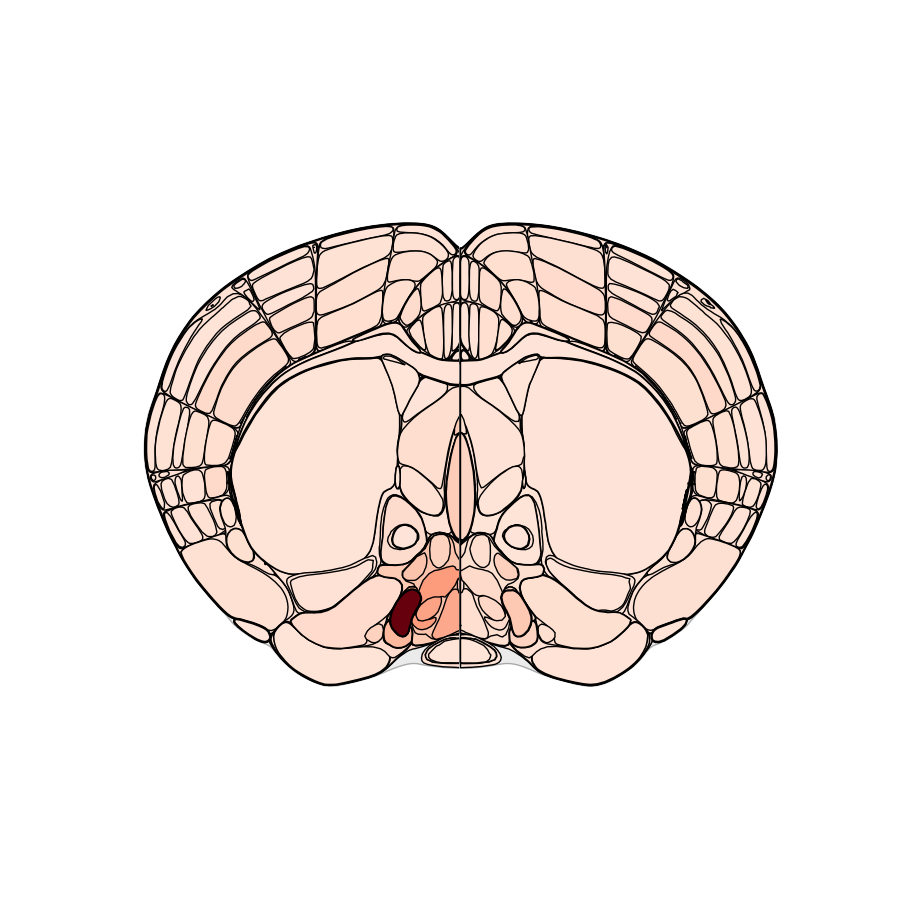

In [7]:
#ATTENTION: ratios
    # if colormap is there: left_ratio=0.493,right_ratio=0.507
    # if colormap is NOT there: left_ratio=0.511,right_ratio=0.489

left_ratio=0.511
right_ratio=0.489


# Load PNG images
img2 = Image.open("/run/user/1000/gvfs/smb-share:server=upcourtinenas,share=cervical/CERVICAL_ID/Connectome_analysis/Final_dataset/DR/8 weeks/100/Results/2D_heatmaps/Left/5000.png")
img1 = Image.open("/run/user/1000/gvfs/smb-share:server=upcourtinenas,share=cervical/CERVICAL_ID/Connectome_analysis/Final_dataset/DR/8 weeks/100/Results/2D_heatmaps/Right/5000.png")

width1, height1 = img1.size
width2, height2 = img2.size
left_crop_width = int(width1 * left_ratio)
right_crop_width = int(width2 * right_ratio)
left_half_img1 = img1.crop((0, 0, left_crop_width, height1))
right_half_img2 = img2.crop((width2 - right_crop_width, 0, width2, height2))
new_width = left_half_img1.width + right_half_img2.width
new_image = Image.new('RGB', (new_width, height1))
new_image.paste(left_half_img1, (0, 0))
new_image.paste(right_half_img2, (left_half_img1.width, 0))

display(new_image)

# Create Video Independently
This cell can help the user to create a video of a single  specific brain, without running for all the project.

In [8]:
# Path to the directory containing the PNG images
image_folder = '/run/user/1000/gvfs/smb-share:server=upcourtinenas,share=cervical/CERVICAL_ID/Connectome_analysis/Final_dataset/DR/8 weeks/100/Results/2D_heatmaps/Merged'
# # Path to save the output video
video_path = image_folder + '/video_merged_heatmaps.mp4'

# Get the list of image files in the folder
images = [img for img in os.listdir(image_folder) if img.endswith(".png")]
images.sort(key=extract_number)  # Optional: sort images if needed
#print(images)

# Read the first image to get the width and height
first_image = cv2.imread(os.path.join(image_folder, images[0]))
height, width, layers = first_image.shape

# Define the codec and create VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'XVID')  # You can use 'MJPG' or 'MP4V' if preferred
fps=5
video = cv2.VideoWriter(video_path, fourcc, fps, (width, height))  # 1 is the frame rate

for image in images:
    image_path = os.path.join(image_folder, image)
    img = cv2.imread(image_path)
    video.write(img)  # Write each frame to the video

# Release the video writer object
video.release()
cv2.destroyAllWindows()

print("Video creation complete!")

OpenCV: FFMPEG: tag 0x44495658/'XVID' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


Video creation complete!
